In [43]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
from functools import partial
import makassar_ml as ml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.model_selection import ParameterGrid
sns.set() # Use seaborn themes.

# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [84]:
def plot(df):
    base_keys = sorted([key for key in df.keys() if key != 'model' and 'val_' not in key and 'test_' not in key])

    n = len(base_keys)
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(12,n*2.5), sharex=True, constrained_layout=True)

    df_melted = df.melt(id_vars='model')
    for i, key in enumerate(base_keys):
        df_melted_subset = df_melted[df_melted['variable'].str.contains(key)]
        g = sns.barplot(x='model', y='value', hue='variable', data=df_melted_subset, ax=ax[i])
        g.legend_.remove()
        y_label = ml.visualization.metrickey2plotlabel(key)
        ax[i].set_ylabel(y_label, fontsize='large')
        ax[i].set_xlabel('Model', fontsize='large')
        ax[i].tick_params(axis='x', labelrotation=10)

        if key=='accuracy':
            ax[i].set(ylim=(0.85, 1.01))

    handles, labels = ax[-1].get_legend_handles_labels()
    labels = ['train', 'val', 'test']
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5,0.0))
    fig.tight_layout()

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_6280/321122112.py:23: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


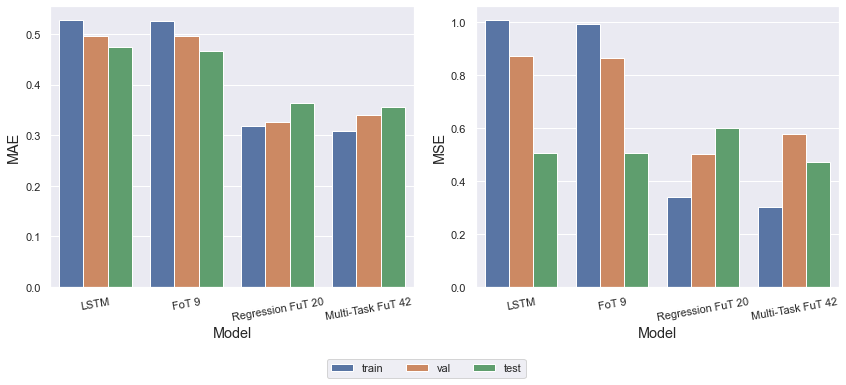

In [85]:
# Regression data.
df_regression = pd.DataFrame([
    {
        'model': 'LSTM',
        'mse': 1.0078,
        'val_mse': 0.8728,
        'test_mse': 0.5044,
        'mae': 0.5284,
        'val_mae': 0.4957,
        'test_mae': 0.4745,
    },
    {
        'model': 'FoT 9',
        'mse': 0.9939,
        'val_mse': 0.8630,
        'test_mse': 0.5057,
        'mae': 0.5258,
        'val_mae': 0.4956,
        'test_mae': 0.4668,
    },
    {
        'model': 'Regression FuT 20',
        'mse': 0.3414,
        'val_mse': 0.5031,
        'test_mse': 0.5999,
        'mae': 0.3194,
        'val_mae': 0.3270,
        'test_mae': 0.3632,
    },
    {
        'model': 'Multi-Task FuT 42',
        'mse': 0.3031,
        'val_mse': 0.5767,
        'test_mse': 0.4734,
        'mae': 0.3092,
        'val_mae': 0.3405,
        'test_mae': 0.3554,
    },
])

plot(df_regression)

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_6280/321122112.py:23: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


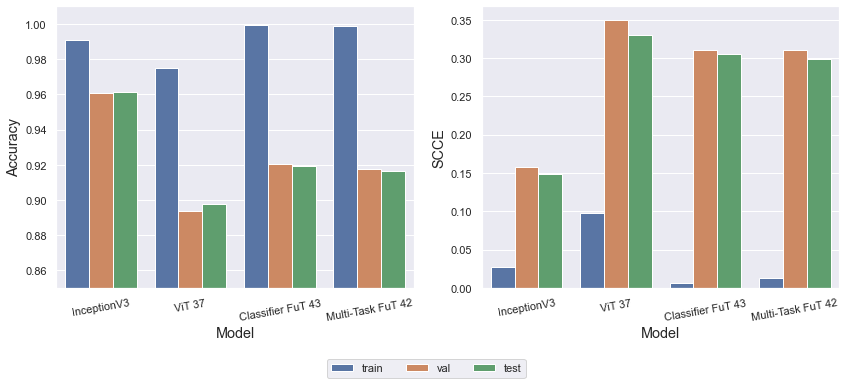

In [86]:
# Classification data.
df_classifier = pd.DataFrame([
    {
    'model': 'InceptionV3',
    'scce': 0.0276,
    'val_scce': 0.1581,
    'test_scce': 0.1490,
    'accuracy': 0.9912,
    'val_accuracy': 0.9606,
    'test_accuracy': 0.9615,
    },
    {
    'model': 'ViT 37',
    'scce': 0.0977,
    'val_scce': 0.3499,
    'test_scce': 0.3307,
    'accuracy': 0.9750,
    'val_accuracy': 0.8936,
    'test_accuracy': 0.8978,
    },
    {
    'model': 'Classifier FuT 43',
    'scce': 0.0064,
    'val_scce': 0.3112,
    'test_scce': 0.3057,
    'accuracy': 0.9994,
    'val_accuracy': 0.9202,
    'test_accuracy': 0.9192,
    },
    {
    'model': 'Multi-Task FuT 42',
    'scce': 0.0135,
    'val_scce': 0.3108,
    'test_scce': 0.2985,
    'accuracy': 0.9987,
    'val_accuracy': 0.9176,
    'test_accuracy': 0.9166,
    },
])

plot(df_classifier)

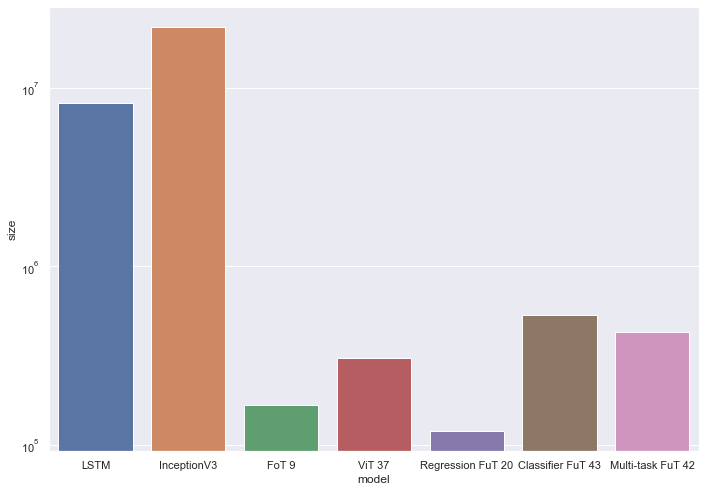

In [97]:
df = pd.DataFrame(
[
('LSTM', 8_191_298), # 30_071_944
('InceptionV3', 21_880_646),
('FoT 9', 167_330), # 476_712
('ViT 37', 309_382),
('Regression FuT 20', 120_042), # 651_928
('Classifier FuT 43', 531_886),
('Multi-task FuT 42', 428_488),
],
columns=['model', 'size']
)


fig = plt.figure(figsize=(10,7))
ax = sns.barplot(x='model', y='size', data=df)
ax.set_yscale("log")
# ax.set(ylim=(115_000, 21_880_646))
fig.tight_layout()

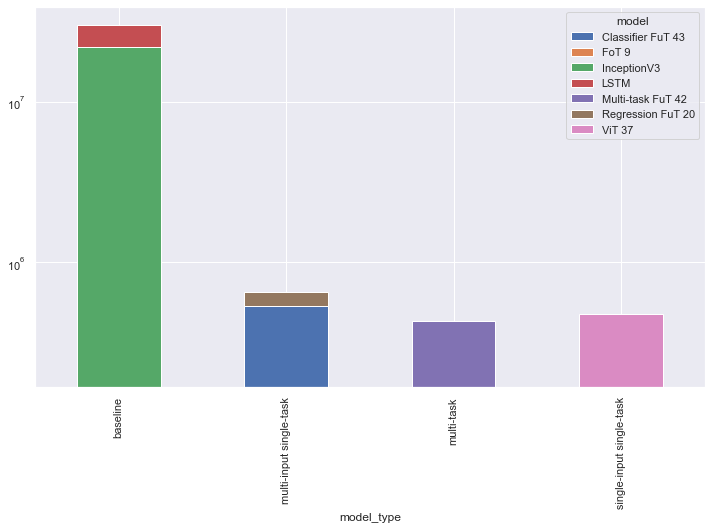

In [142]:
df = pd.DataFrame(
[
('baseline', 'LSTM', 8_191_298), # 30_071_944
('baseline', 'InceptionV3', 21_880_646),
('single-input single-task', 'FoT 9', 167_330), # 476_712
('single-input single-task', 'ViT 37', 309_382),
('multi-input single-task', 'Regression FuT 20', 120_042), # 651_928
('multi-input single-task', 'Classifier FuT 43', 531_886),
('multi-task', 'Multi-task FuT 42', 428_488),
],
columns=['model_type', 'model', 'size']
)
df.head()


# fig = plt.figure(figsize=(20,10))

# print(df.pivot_table(index=['model_type'], columns=['model'], values='size'))
df.pivot_table(index=['model_type'], columns=['model'], values='size').plot(kind='bar', stacked=True, figsize=(12,7))
# df_pivot = df.pivot_table(index=['model_type'], columns=['model'], values='size')
# sns.barplot(x='model_type', y='size', hue='model', data=df_pivot)

# df.pivot(index=['model_type'], columns=['model', 'size'])

# df.groupby('model_type')
# df.melt('model_type')

# # df = df.set_index('model_type')



# # df.groupby('model_type').sum().T.plot(kind='bar', stacked=True)

# ax = sns.barplot(x='model_type', y='size', hue='model', data=df.groupby('model_type').sum().T)
ax=plt.gca()
ax.set_yscale("log")
# # # ax.set(ylim=(115_000, 21_880_646))
# fig.tight_layout()

In [ ]:
labels = ['single-input single-task', 'multi-input single-task', 'multi-task']
l0 = []